# Opioid Epidemic Exploratory Data Analysis

### Analyst: Ethan Wright

In [1]:
# Dependencies and Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import scipy.stats as sts
import seaborn
import pingouin as pg
from pingouin import pairwise_ttests

### Import opioid mortality rate dataset (Health04) which contains State average opioid mortality rates for year range 2014-2019 & a period average labeled odMortRtAv

In [35]:
health04_S_file_path = "../Resources/Health04/Health04_S.csv"
mortality_data = pd.read_csv(health04_S_file_path)
mortality_df = pd.DataFrame(mortality_data)
mortality_df.head(3)

### Create a dataframe with state abbreviation and opioid mortality rate from mortality_data

mort_df = mortality_df.loc[:,['st_abb', 'odMortRtAv']]
mort_df = mort_df.rename(columns={'st_abb' : 'STATE', 'odMortRtAv' : 'odMortRtAv'})
mort_df.head(3)

### Import state_region.csv - which pairs the U.S. states with their respective Region and Division

region_file_path = "../Resources/Geographic/state_region.csv"
region_data = pd.read_csv(region_file_path)
region_df = pd.DataFrame(region_data).loc[:,['State Code', 'Region', 'Division']].rename(columns={'State Code' : 'STATE', 'Region' : 'Region', 'Division' : 'Division'})
region_df.head(3)

### Merge the opioid mortality rate and state region DataFrames in order to analyze regional differences

mort_region_df = pd.merge(region_df, mort_df, on="STATE", how="inner")
mort_region_df.head(3)

,STATE,Region,Division,odMortRtAv
0,AK,West,Pacific,17.03
1,AL,South,East South Central,16.33
2,AR,South,West South Central,14.18


### Create choropleth map of opioid mortality rate by State

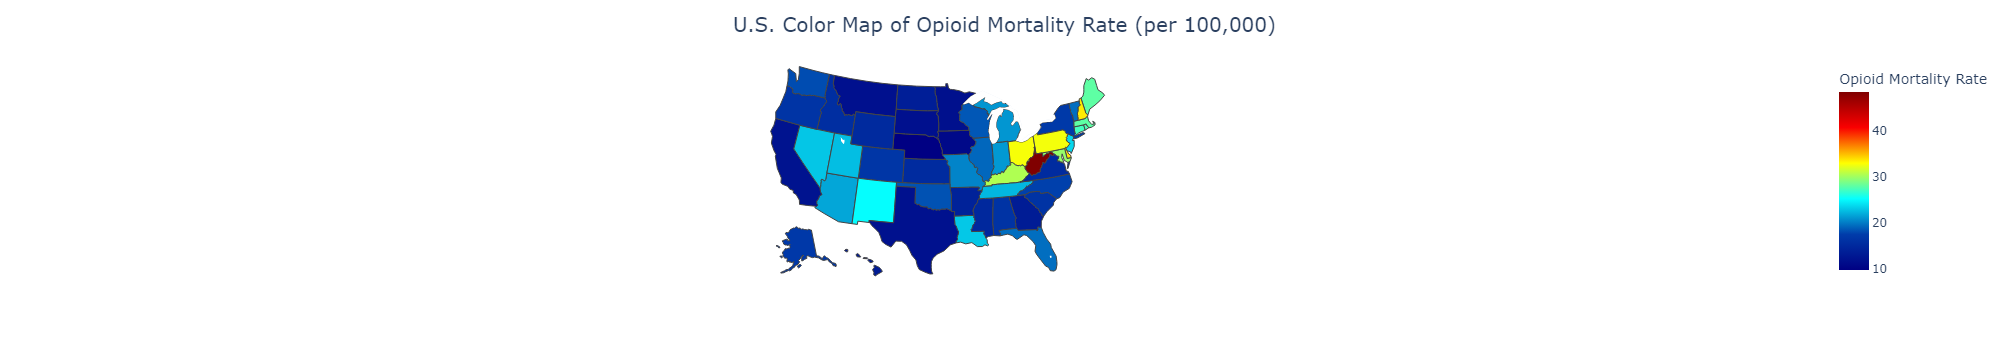

In [45]:
fig1 = px.choropleth(mort_region_df,
                    locations='STATE',
                    color='odMortRtAv',
                    color_continuous_scale='jet',
                    hover_name='STATE',
                    labels={'odMortRtAv':'Opioid Mortality Rate'},
                    locationmode='USA-states',
                    scope='usa')

fig1.update_layout(
    title=dict(text="U.S. Color Map of Opioid Mortality Rate (per 100,000)", x=0.5, y=.95), title_font_size = 20
)

fig1.show()

In [2]:
### Import NSSATS_PUF_2020_CSV: the survey-based dataset on substance abuse treatment services nationwide 

nssats_file_path = "../Resources/NSSATS/NSSATS_PUF_2020_CSV.csv"

facility_data = pd.read_csv(nssats_file_path, low_memory=False)
facility_data.head(3)

facility_df = pd.DataFrame(facility_data)
facility_df.shape

### Remove the jurisdictions ('PR' and 'ZZ') that are not included in Health04 dataset

rejected_state_codes = ['PR', 'ZZ']
facility_rejected_state_s = facility_df.STATE.isin(rejected_state_codes)
facility_rejected_state_s

facility_df[~facility_rejected_state_s] #with or without loc same output

fac_df = facility_df.loc[~facility_df.STATE.isin(rejected_state_codes)]
fac_df

fac_df = facility_df.loc[facility_df.STATE != 'PR'].loc[facility_df.STATE != 'ZZ']
fac_df.STATE.nunique()

### Merge the opioid mortality and treatment facility datasets

df = pd.merge(mort_region_df, fac_df, on = "STATE", how = "inner") 
print(df.shape)
df.head(3)

(15955, 265)


,STATE,Region,Division,odMortRtAv,CASEID,STFIPS,DETOX,TREATMT,SMISEDSUD,OWNERSHP,...,T_CLIHI_X,T_CLIML_D,T_CLIML_O,T_CLIML_X,T_CLIOP_D,T_CLIOP_O,T_CLIOP_X,T_CLIRC_D,T_CLIRC_O,T_CLIRC_X
0,AK,West,Pacific,17.03,1,2,0,1,1,6,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN
1,AK,West,Pacific,17.03,2,2,0,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,AK,West,Pacific,17.03,3,2,1,1,0,2,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN


## OTP: Facility operates an opioid treatment program

In [3]:
df.OTP.value_counts()

0    14208
1     1747
Name: OTP, dtype: int64

## Create a 'naive' calculated variable that aims to quantify the extent (or sheer quantity) of resources offered by a treatment facility.

### Treatment Facility Quality (TFQ) - average of standardized (0-10) scores for ASSESSMENT, TESTING, TRANSITION, RECOVERY, EDUCATION, and PHARMACOTHERAPIES services offered by treatment facilities

In [4]:
a = df.ASSESSMENT #(0-8)
b = df.TESTING #(0-9)
c = df.TRANSITION #(0-4)
d = df.RECOVERY #(0-6)
e = df.EDUCATION #(0-10)
f = df.PHARMACOTHERAPIES #(0-16)

### Define function to standardize resource-related scales to 0-10.

In [5]:
TFQ_STANDARD_SCALE_MAX = 10

def scale(raw_metric):
    raw_max = raw_metric.max()
    scaled_metric = raw_metric * (TFQ_STANDARD_SCALE_MAX / raw_max)
    return scaled_metric

### Add calculated variable to main df

In [6]:
TFQ_RAW_DIMENSIONS = ['ASSESSMENT', 'TESTING', 'TRANSITION', 'RECOVERY', 'EDUCATION', 'PHARMACOTHERAPIES']

for col in TFQ_RAW_DIMENSIONS:
  df[col + '_SCALED'] = scale(df[col])

TFQ_DIMENSIONS =  [col + '_SCALED' for col in TFQ_RAW_DIMENSIONS] #syntactic sugar

df[TFQ_DIMENSIONS]

,ASSESSMENT_SCALED,TESTING_SCALED,TRANSITION_SCALED,RECOVERY_SCALED,EDUCATION_SCALED,PHARMACOTHERAPIES_SCALED
0,8.75,1.111111,7.5,6.666667,9.0,0.000
1,6.25,2.222222,7.5,10.000000,10.0,9.375
2,7.50,4.444444,7.5,5.000000,8.0,1.875
3,10.00,3.333333,10.0,6.666667,9.0,0.625
4,7.50,10.000000,10.0,6.666667,8.0,8.125
...,...,...,...,...,...,...
15950,8.75,1.111111,5.0,6.666667,7.0,0.625
15951,8.75,4.444444,7.5,8.333333,8.0,4.375
15952,8.75,2.222222,7.5,6.666667,9.0,3.750
15953,7.50,1.111111,7.5,6.666667,9.0,0.000


In [7]:
df[TFQ_DIMENSIONS].mean(axis=1) #check work

0        5.504630
1        7.557870
2        5.719907
3        6.604167
4        8.381944
           ...   
15950    4.858796
15951    6.900463
15952    6.314815
15953    5.296296
15954    5.856481
Length: 15955, dtype: float64

### Get summary statistics for TFQ

In [14]:
df['TFQ'] = df[TFQ_DIMENSIONS].mean(axis=1)
tfq = df.TFQ
tfq.describe()

count    15955.000000
mean         5.517217
std          1.726054
min          0.208333
25%          4.282407
50%          5.555556
75%          6.761574
max         10.000000
Name: TFQ, dtype: float64

### Subset the main dataset down to only facilities with OTPs 

In [16]:
otp_df = df[df.OTP == 1]
otp_df.shape

(1747, 272)

### Get summary statistics on OTP facility TFQ

In [18]:
otp_df.TFQ.describe()

count    1747.000000
mean        6.180479
std         1.498491
min         1.456019
25%         5.165509
50%         6.187500
75%         7.270833
max        10.000000
Name: TFQ, dtype: float64

### Subset df down to non-OTP offering facilities

In [19]:
no_otp_df = df[df.OTP == 0]
no_otp_df.shape

(14208, 272)

### Get summary statistics on non-OTP offering facilities

In [21]:
no_otp_df.TFQ.describe()

count    14208.000000
mean         5.435663
std          1.734619
min          0.208333
25%          4.171296
50%          5.472222
75%          6.668981
max         10.000000
Name: TFQ, dtype: float64

### Plot TFQ using Boxplot Grouped by OTP (0 : "Does not have OTP", 1 : "Has OTP")

<AxesSubplot:title={'center':'TFQ'}, xlabel='OTP'>

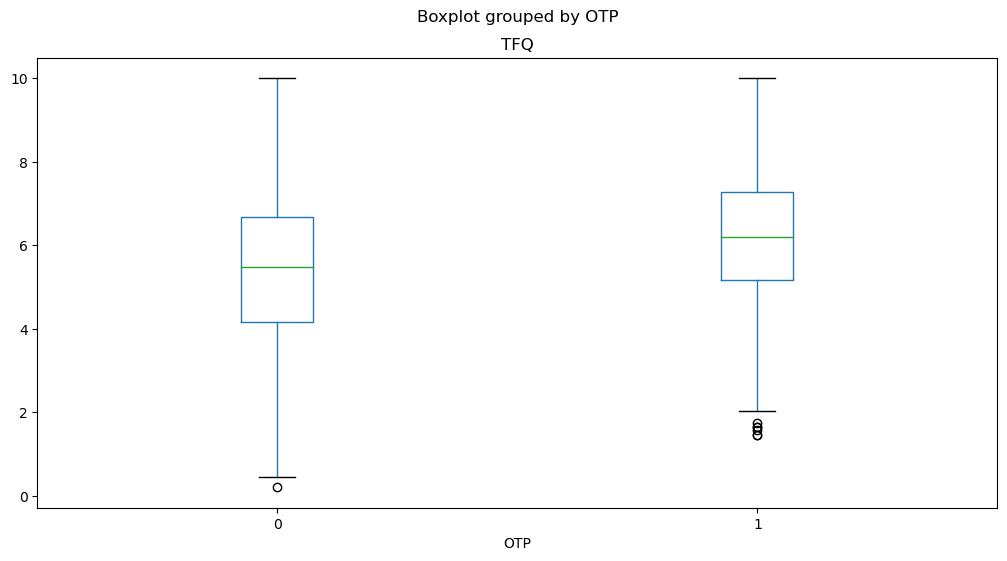

In [23]:
df.boxplot("TFQ", by="OTP", grid=False, figsize=(12, 6))

### Run one-way ANOVA on TFQ by OTP classification

In [25]:
sts.f_oneway(no_otp_df.TFQ, otp_df.TFQ)

F_onewayResult(statistic=295.0181459514937, pvalue=1.5570413920283307e-65)

### Generate Boxplot for OTP Facility TFQ between Regions

<AxesSubplot:title={'center':'TFQ'}, xlabel='Region'>

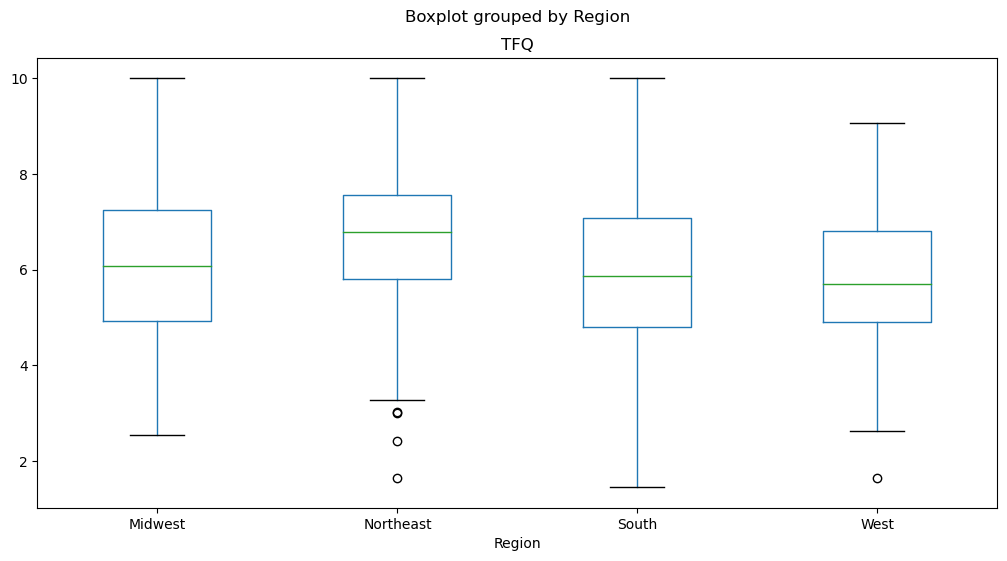

In [28]:
otp_df.boxplot("TFQ", by="Region", grid=False, figsize=(12, 6))

#plt.savefig('Figures/TFQ_Boxplot_Region.png')

### Run one-way ANOVA on OTP Facility TFQ by Region

In [29]:
WEST = otp_df[otp_df["Region"] == 'West']['TFQ']
SOUTH = otp_df[otp_df["Region"] == 'South']['TFQ']
NORTHEAST = otp_df[otp_df["Region"] == 'Northeast']['TFQ']
MIDWEST = otp_df[otp_df["Region"] == 'Midwest']['TFQ']

sts.f_oneway(WEST, SOUTH, NORTHEAST, MIDWEST)

F_onewayResult(statistic=33.85417162495234, pvalue=2.8973363667957014e-21)

### Run pairwise ttests on OTP TFQ by Region

In [32]:
otp_tfq_pairwise_gameshowell = pg.pairwise_gameshowell(data=otp_df, dv="TFQ", between="Region").sort_values(['pval'], ascending = True).set_index('A')
otp_tfq_pairwise_gameshowell

,B,mean(A),mean(B),diff,se,T,df,pval,hedges
A,,,,,,,,,
Northeast,West,6.703125,5.881247,0.821878,0.092450,8.889973,720.410810,2.020606e-14,0.621625
Northeast,South,6.703125,5.908094,0.795031,0.086329,9.209360,1084.384417,2.784439e-13,0.550163
Midwest,Northeast,6.161982,6.703125,-0.541143,0.108176,-5.002409,513.212449,4.638953e-06,-0.386454
Midwest,West,6.161982,5.881247,0.280736,0.118039,2.378339,589.166955,8.238375e-02,0.189351
Midwest,South,6.161982,5.908094,0.253888,0.113308,2.240692,590.124656,1.135943e-01,0.160315
South,West,5.908094,5.881247,0.026847,0.098405,0.272822,823.344424,9.929008e-01,0.017798


### Discussion: A pairwise ttest reveals that their significant differences between several Region pairs. Noteably, mean TFQ scores of OTP facilties in the Northeast are significantly different from those of all three other regions (West, South, & Midwest) and represent the largest observed differences in means.

# Question: How might I characterize and visualize the TFQ composition a facility? And compare that visual across regions?

### Now that a difference in TFQ (at the aggregate level) has been identified. Disaggregate TFQ or discover feature importance. 

In [33]:
otp_tfq_pairwise_gameshowell.to_csv("Results/OTP_TFQ_pairwise_ttest_results.csv")

### Create plotly scatter plot with wrapping column facets for xyz

In [145]:
a = df.ASSESSMENT #(0-8)
b = df.TESTING #(0-9)
c = df.TRANSITION #(0-4)
d = df.RECOVERY #(0-6)
e = df.EDUCATION #(0-10)
f = df.PHARMACOTHERAPIES #(0-16)

In [146]:
df.columns

Index(['STATE', 'Region', 'Division', 'odMortRtAv', 'CASEID', 'STFIPS',
       'DETOX', 'TREATMT', 'SMISEDSUD', 'OWNERSHP',
       ...
       'T_CLIRC_D', 'T_CLIRC_O', 'T_CLIRC_X', 'ASSESSMENT_SCALED',
       'TESTING_SCALED', 'TRANSITION_SCALED', 'RECOVERY_SCALED',
       'EDUCATION_SCALED', 'PHARMACOTHERAPIES_SCALED', 'TFQ'],
      dtype='object', length=272)

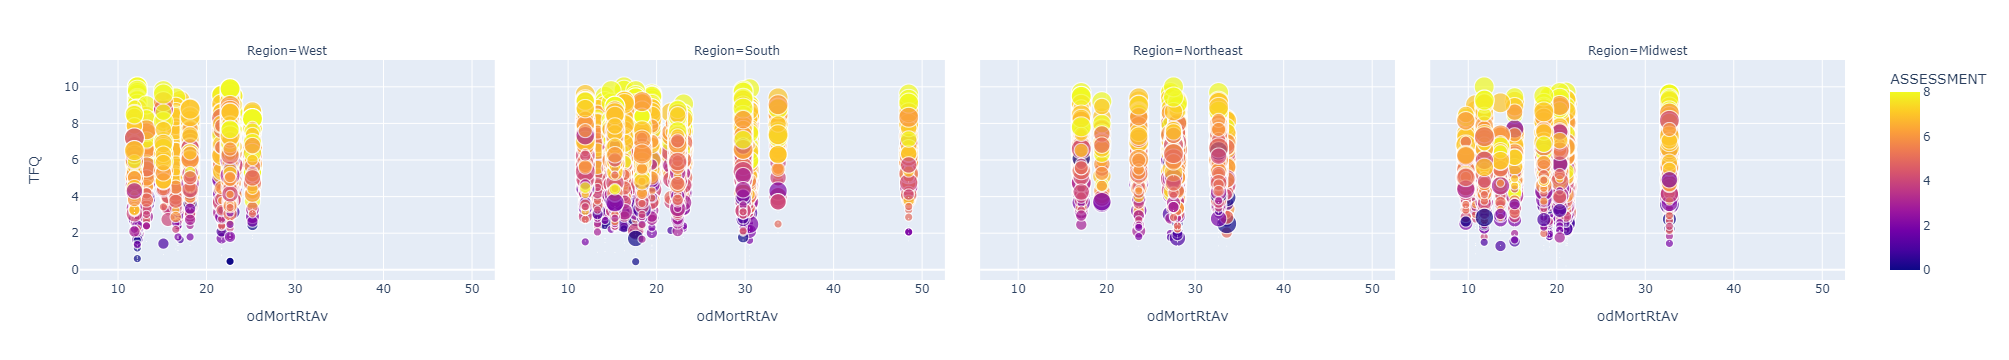

In [148]:
fig = px.scatter(otp_df, x='odMortRtAv', y='TFQ', color='ASSESSMENT', size='RECOVERY',
                facet_col='Region', facet_col_wrap=4)
fig.show()

In [86]:
omr = df['odMortRtAv']
omr.describe()

count    15955.000000
mean        20.039247
std          6.985984
min          9.750000
25%         14.880000
50%         18.570000
75%         23.070000
max         48.520000
Name: odMortRtAv, dtype: float64

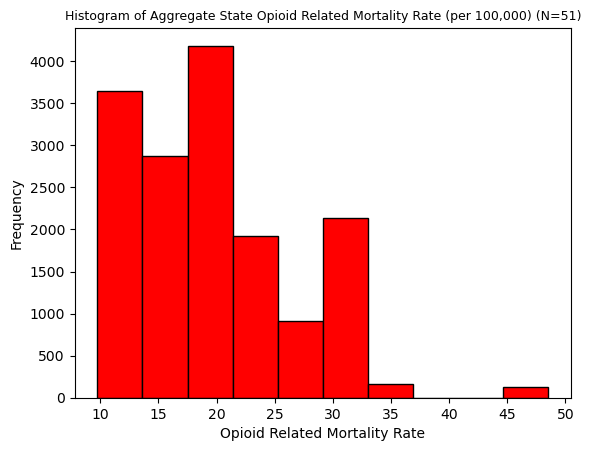

In [149]:
omr.plot.hist(color = 'red', edgecolor = 'black')
plt.title(f"Histogram of Aggregate State Opioid Related Mortality Rate (per 100,000) (N={len(mort_df)})", size = 9)
plt.xlabel("Opioid Related Mortality Rate")
plt.show()

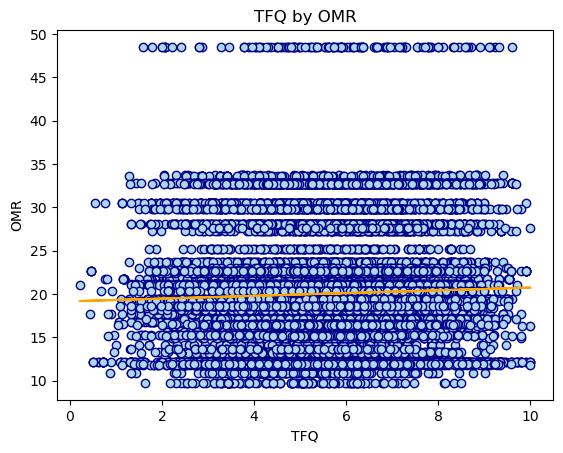

In [150]:
a, b = np.polyfit(tfq, omr, 1)

plt.scatter(tfq, omr, color = 'lightblue', edgecolor = 'darkblue')
plt.plot(tfq, a*tfq+b, color = 'orange')
plt.title("TFQ by OMR")
plt.xlabel("TFQ")
plt.ylabel("OMR")
plt.show()

In [62]:
# Percent of average OMR change for every 1 TFQ point
round(a/omr.mean()*100,2)

0.79

### Aggregate by State

In [151]:
tfq_groupby = df.groupby('STATE')['TFQ'].mean()
tfq_groupby_df = pd.DataFrame(tfq_groupby)
df2 = tfq_groupby_df.reset_index()
df2.head(2)

,STATE,TFQ
0,AK,5.700838
1,AL,5.414606


In [152]:
df3 = pd.merge(mort_region_df, df2, on = "STATE", how = "inner")
print(df3.shape)
df3.head()

(51, 5)


,STATE,Region,Division,odMortRtAv,TFQ
0,AK,West,Pacific,17.03,5.700838
1,AL,South,East South Central,16.33,5.414606
2,AR,South,West South Central,14.18,5.092457
3,AZ,West,Mountain,21.72,5.612644
4,CA,West,Pacific,12.18,5.683144


### Plot TFQ by OMR adding a line of best fit

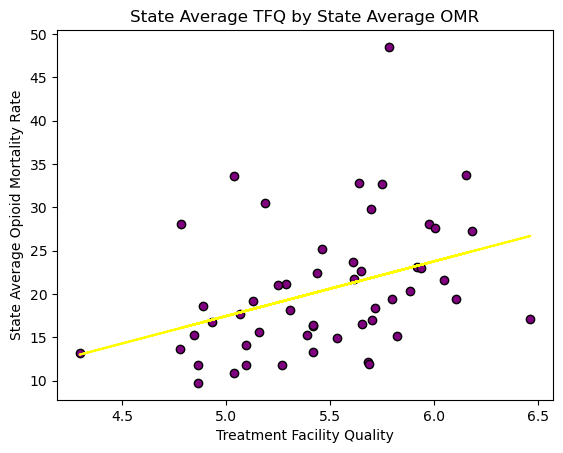

In [153]:
x = df3.TFQ
y = df3.odMortRtAv

a, b = np.polyfit(x, y, 1)

res = sts.pearsonr(x, y)
correlation = res[0].round(2)

plt.scatter(x, y, color = 'purple', edgecolor = 'black')
plt.plot(x, a*x+b, color = 'yellow')
plt.title("State Average TFQ by State Average OMR")
plt.xlabel("Treatment Facility Quality")
plt.ylabel("State Average Opioid Mortality Rate")
plt.savefig('Figures/TFQ_odMortRtAv_Scatter_Regress.png')
plt.show()

### Plot TFQ by OMR adding a line of best fit

In [155]:
x = df3.TFQ
y = df3.odMortRtAv
res = sts.linregress(x, y)
print(f"R-squared: {res.rvalue**2:.6f}")

R-squared: 0.137493


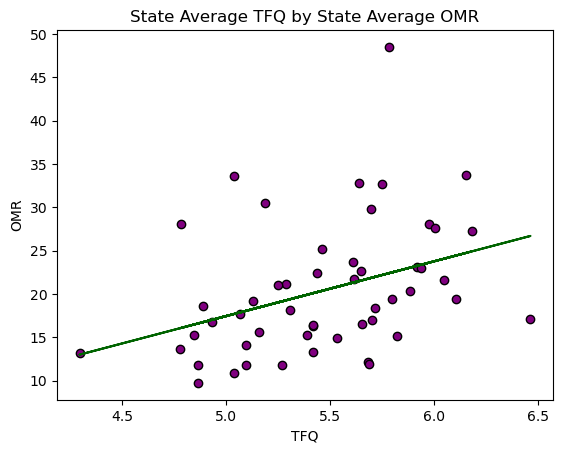

In [156]:
plt.scatter(x, y, color = 'purple', edgecolor = 'black', label='Original Data')
plt.plot(x, res.intercept + res.slope*x, 'darkgreen', label='Fitted Line')
plt.title("State Average TFQ by State Average OMR")
plt.xlabel("TFQ")
plt.ylabel("OMR")
plt.show()

### Note: Block out states by region of country to control for regional factors

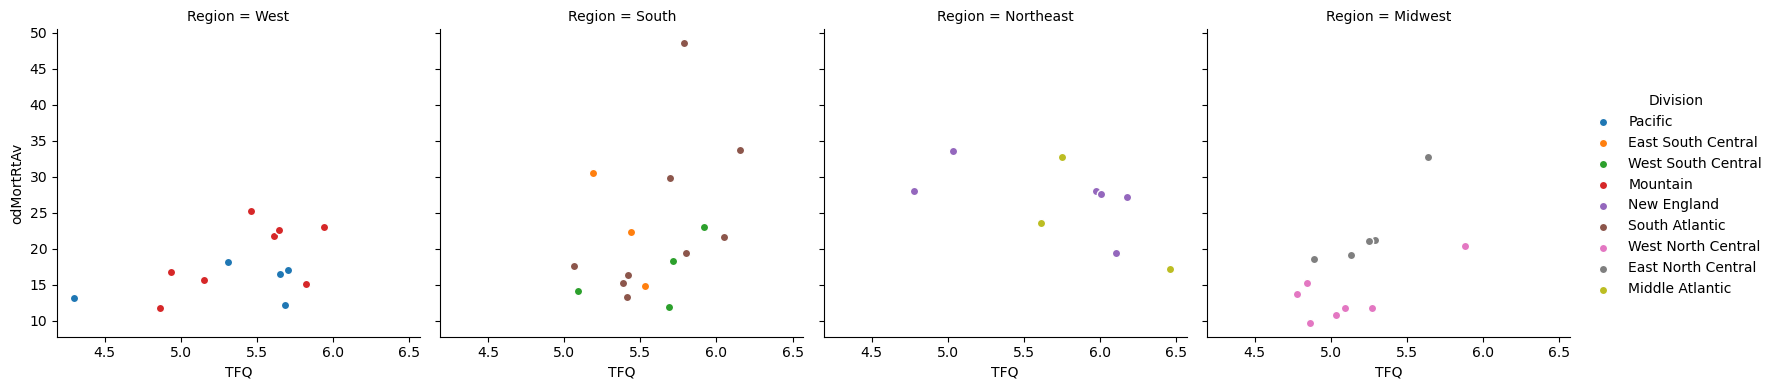

In [158]:
res = sts.linregress(df3.TFQ, df3.odMortRtAv)
# Form a facetgrid using columns with a hue
graph = seaborn.FacetGrid(df3, col ="Region",  hue ="Division", height = 4)
# map the above form facetgrid with some attributes
graph.map(plt.scatter, "TFQ", "odMortRtAv", edgecolor ="w").add_legend()
# show the object
plt.show()

In [159]:
regions = list(df3.Region.unique())
statistics = {}
for region in regions:
    subset = df3.loc[df3['Region'] == region]
    result = sts.linregress(subset.TFQ, subset.odMortRtAv)
    statistics[region] = result
statistics

{'West': LinregressResult(slope=4.2943662673512355, intercept=-5.521522284413507, rvalue=0.4636697740604558, pvalue=0.11051035310700184, stderr=2.474182000638377, intercept_stderr=13.381049068057122),
 'South': LinregressResult(slope=11.709494880223083, intercept=-43.633413936882896, rvalue=0.3932564953265708, pvalue=0.11837471659179431, stderr=7.068621594328721, intercept_stderr=39.4508562684062),
 'Northeast': LinregressResult(slope=-5.984649595849862, intercept=60.894294475971165, rvalue=-0.5986104806655508, pvalue=0.08855341702141366, stderr=3.0269115684189085, intercept_stderr=17.52583653060862),
 'Midwest': LinregressResult(slope=12.233344955095541, intercept=-45.960689658658055, rvalue=0.630452774378319, pvalue=0.027967085675054175, stderr=4.7630127823804695, intercept_stderr=24.639197539857147)}

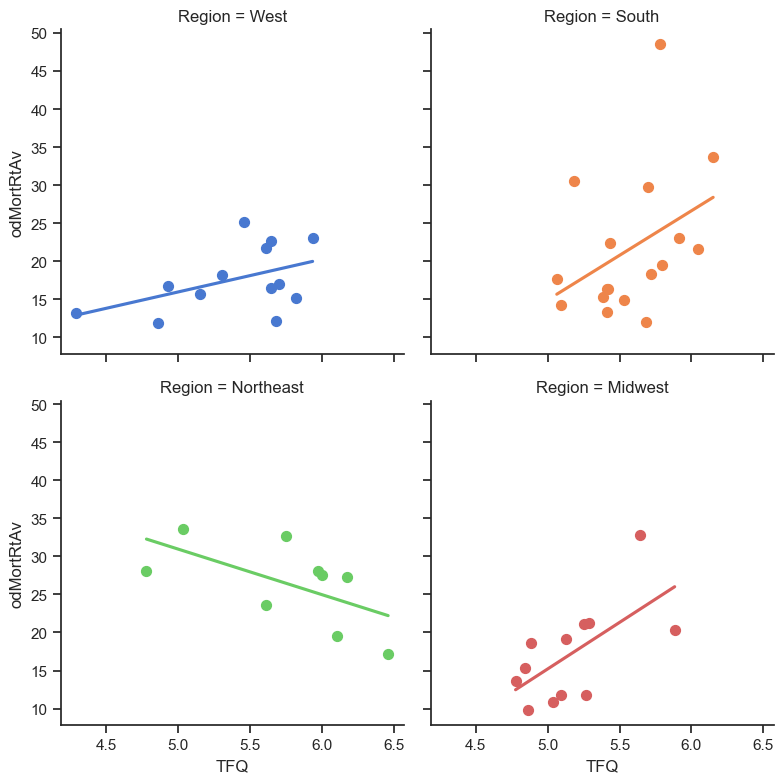

In [161]:
seaborn.set_theme(style="ticks")
seaborn.lmplot(
    data=df3, x="TFQ", y="odMortRtAv", col="Region", hue="Region",
    col_wrap=2, palette="muted", ci=None,
    height=4, scatter_kws={"s": 50, "alpha": 1}
)
.savefig('Figures/Seaborn_Regional_lmplot.png')

# Binning - for further analysis

In [ ]:
tfq_groupby.plot.hist(figsize=[5,5],color='purple',edgecolor='black')
plt.show()

In [53]:
tfq_bins = [0, 22, 29, 35.5, 52]
tfq_bin_names = ["D", "C", "B", "A"]

df['TFQ_BIN'] = pd.cut(df['TFQ'], tfq_bins, labels=tfq_bin_names, include_lowest=True)
df.TFQ_BIN.value_counts()

C    4179
B    4063
D    3976
A    3737
Name: TFQ_BIN, dtype: int64

<AxesSubplot:ylabel='Frequency'>

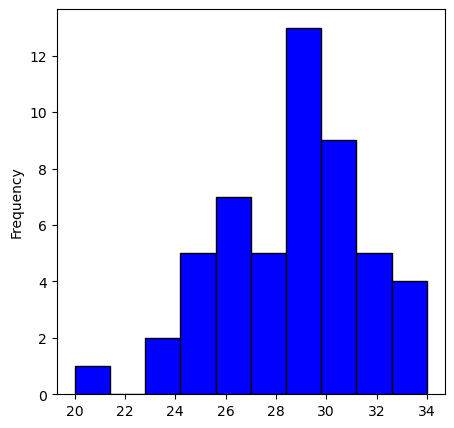

In [50]:
tfq_groupby = df.groupby('STATE')['TFQ'].median()
tfq_groupby.plot.hist(figsize=[5,5],color='blue',edgecolor='black')

## Directions for future research:
### 1. Machine Learning: Regression on Individual Paramters --> Feature Importance
### 2. Multi-Variate Linear Regression --> TFQ might crumble because some parameters don't matter
### 3. Feature Importance! (Direction worth researching) --> which dimensions really matter 